In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import astropy.cosmology as cosmo
import astropy.units as u
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import seaborn as sns

from pymc_cosmology.models import make_chirp_mass_mf_cosmology_model

sns.set_context('notebook')

Here we draw an example data set.  Note: we choose the luminosity distance uncertainty to be 30% at $z = z_\mathrm{max}$, and truncate it at 2%, even for exceptionally nearby events.  The sampling is quite sensitive to the distance uncertainty; too much smaller uncertainty floor than this, and the sampling explodes, even after we have played a lot of tricks in the model to respect the small distance uncertainties.  TODO: figure out why the model seems to explode.

In [3]:
zmax = 10
C = cosmo.Planck18
Nz = 1024
N = 256

mc_mean = 2*1.35*0.25**(3/5)
mc_std = 0.1*mc_mean

zi = np.expm1(np.linspace(np.log(1), np.log(1+zmax), Nz))
zden = (1+zi)**2.7/(1+((1+zi)/(1+1.9))**5.6)*C.differential_comoving_volume(zi).to(u.Gpc**3/u.sr).value/(1+zi)
zcum = np.concatenate([[0.0], np.cumsum(0.5*np.diff(zi)*(zden[1:]+zden[:-1]))])

def slogdl(log_dl):
    dMax = C.luminosity_distance(zmax).to(u.Gpc).value
    return max(0.3*np.exp(log_dl)/dMax, 0.02) # 30% uncertainty in distance at maximum redshift, floors out at 2% uncertainty

mcs = []
zs = []
mc_dets = []
log_dl_obs = []
sigma_log_dl = []
while len(mcs) < N:
    z = np.interp(np.random.uniform(low=0, high=zcum[-1]), zcum, zi)
    mc = np.random.normal(loc=mc_mean, scale=mc_std)
    mco = mc*(1+z)
    logd = np.log(C.luminosity_distance(z).to(u.Gpc).value)
    sld = slogdl(logd)
    logdo = logd + sld*np.random.randn()

    mcs.append(mc)
    mc_dets.append(mco)
    zs.append(z)
    log_dl_obs.append(logdo)
    sigma_log_dl.append(sld)
mcs, zs, mc_dets, log_dl_obs, sigma_log_dl = map(np.array, [mcs, zs, mc_dets, log_dl_obs, sigma_log_dl])

Distance-redshift (mixing observed and true quantities), and distance-chirp-mass (all observed quantities).

Text(0, 0.5, '$d_L / \\mathrm{Gpc}$')

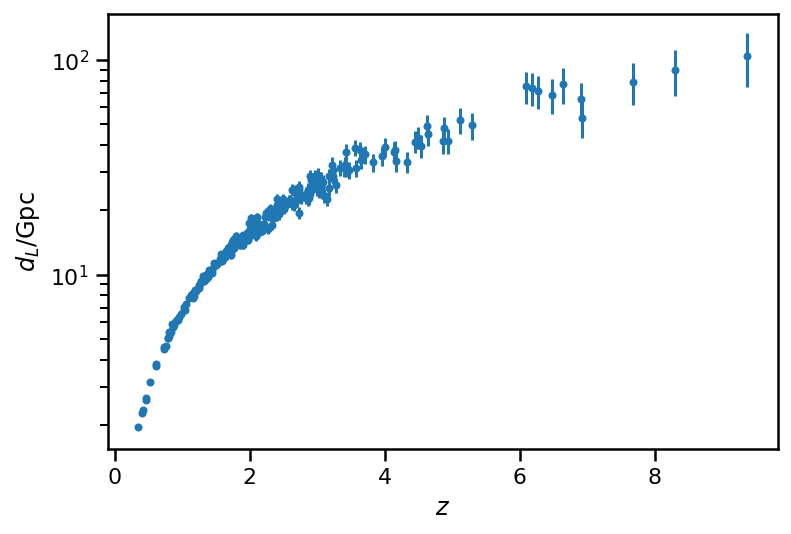

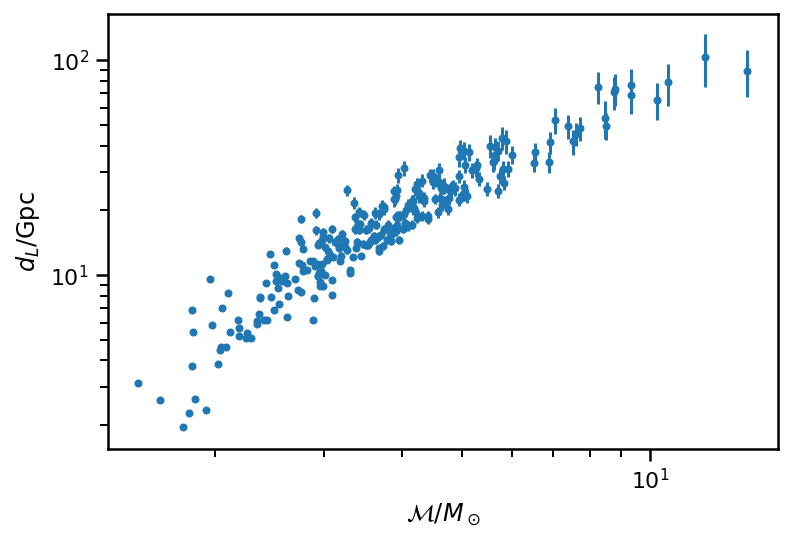

In [4]:
plt.errorbar(zs, np.exp(log_dl_obs), yerr=sigma_log_dl*np.exp(log_dl_obs), fmt='.')
plt.yscale('log')
plt.xlabel(r'$z$')
plt.ylabel(r'$d_L / \mathrm{Gpc}$')

plt.figure()
plt.errorbar(mc_dets, np.exp(log_dl_obs), yerr=sigma_log_dl*np.exp(log_dl_obs), fmt='.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\mathcal{M} / M_\odot$')
plt.ylabel(r'$d_L / \mathrm{Gpc}$')

Good initialization seems to be important, too; these are all the true values of the parameters used for initialization.

In [5]:
init = {
    'mu_mc': mc_mean,
    'sigma_mc': mc_std,
    'a': 2.7,
    'z_p': 1.9,
    'c': 5.6,
    'h': C.H0/100,
    'Om': C.Om0,
    'w': -1,
    'log_dl_unit': np.zeros_like(mc_dets)
}

with make_chirp_mass_mf_cosmology_model(mc_dets, log_dl_obs, sigma_log_dl, zmax=10) as model:
    trace = pm.sample(initvals=init)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/wfarr/miniconda3/envs/pymc_cosmology/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_mc, sigma_mc, a, z_p, c, om, ode, w, log_dl_unit]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 219 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Looks pretty good:

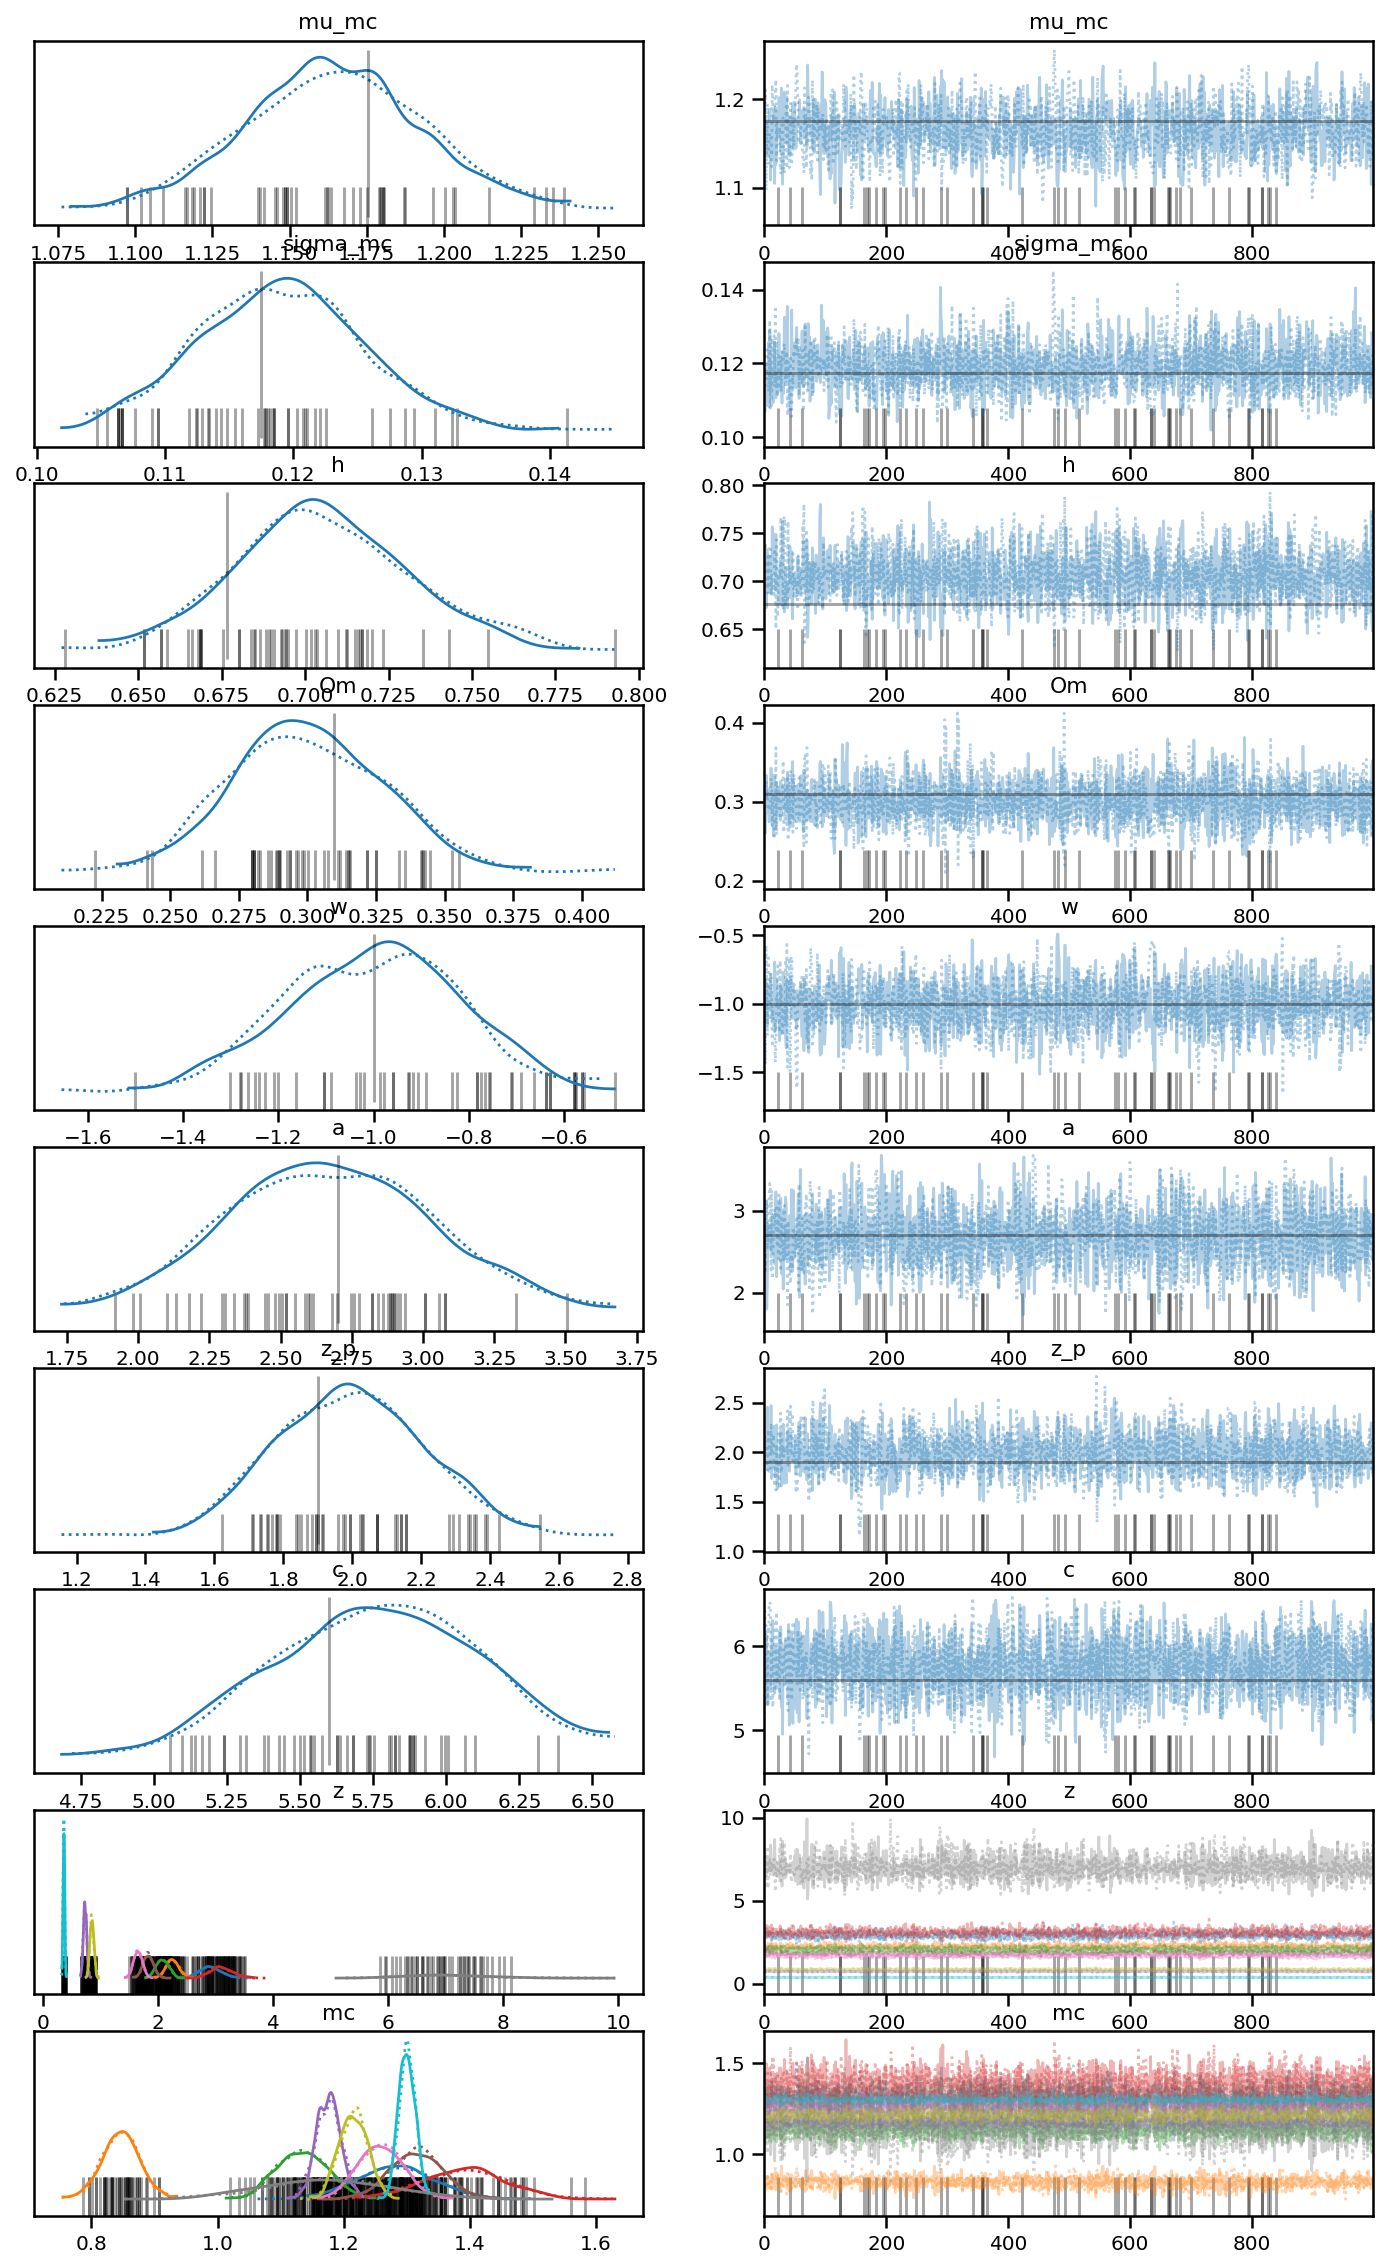

In [8]:
with model:
    az.plot_trace(trace, var_names=['mu_mc', 'sigma_mc', 'h', 'Om', 'w', 'a', 'z_p', 'c', 'z', 'mc'], 
                  lines=[('mu_mc', {}, mc_mean), ('sigma_mc', {}, mc_std), ('h', {}, C.H0/100), ('Om', {}, C.Om0), ('w', {}, -1),
                         ('a', {}, 2.7), ('z_p', {}, 1.9), ('c', {}, 5.6)],
                  coords={'mc_dim_0': np.arange(10), 'z_dim_0': np.arange(10)})

array([[<AxesSubplot:ylabel='sigma_mc'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='h'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Om'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='mu_mc', ylabel='w'>,
        <AxesSubplot:xlabel='sigma_mc'>, <AxesSubplot:xlabel='h'>,
        <AxesSubplot:xlabel='Om'>]], dtype=object)

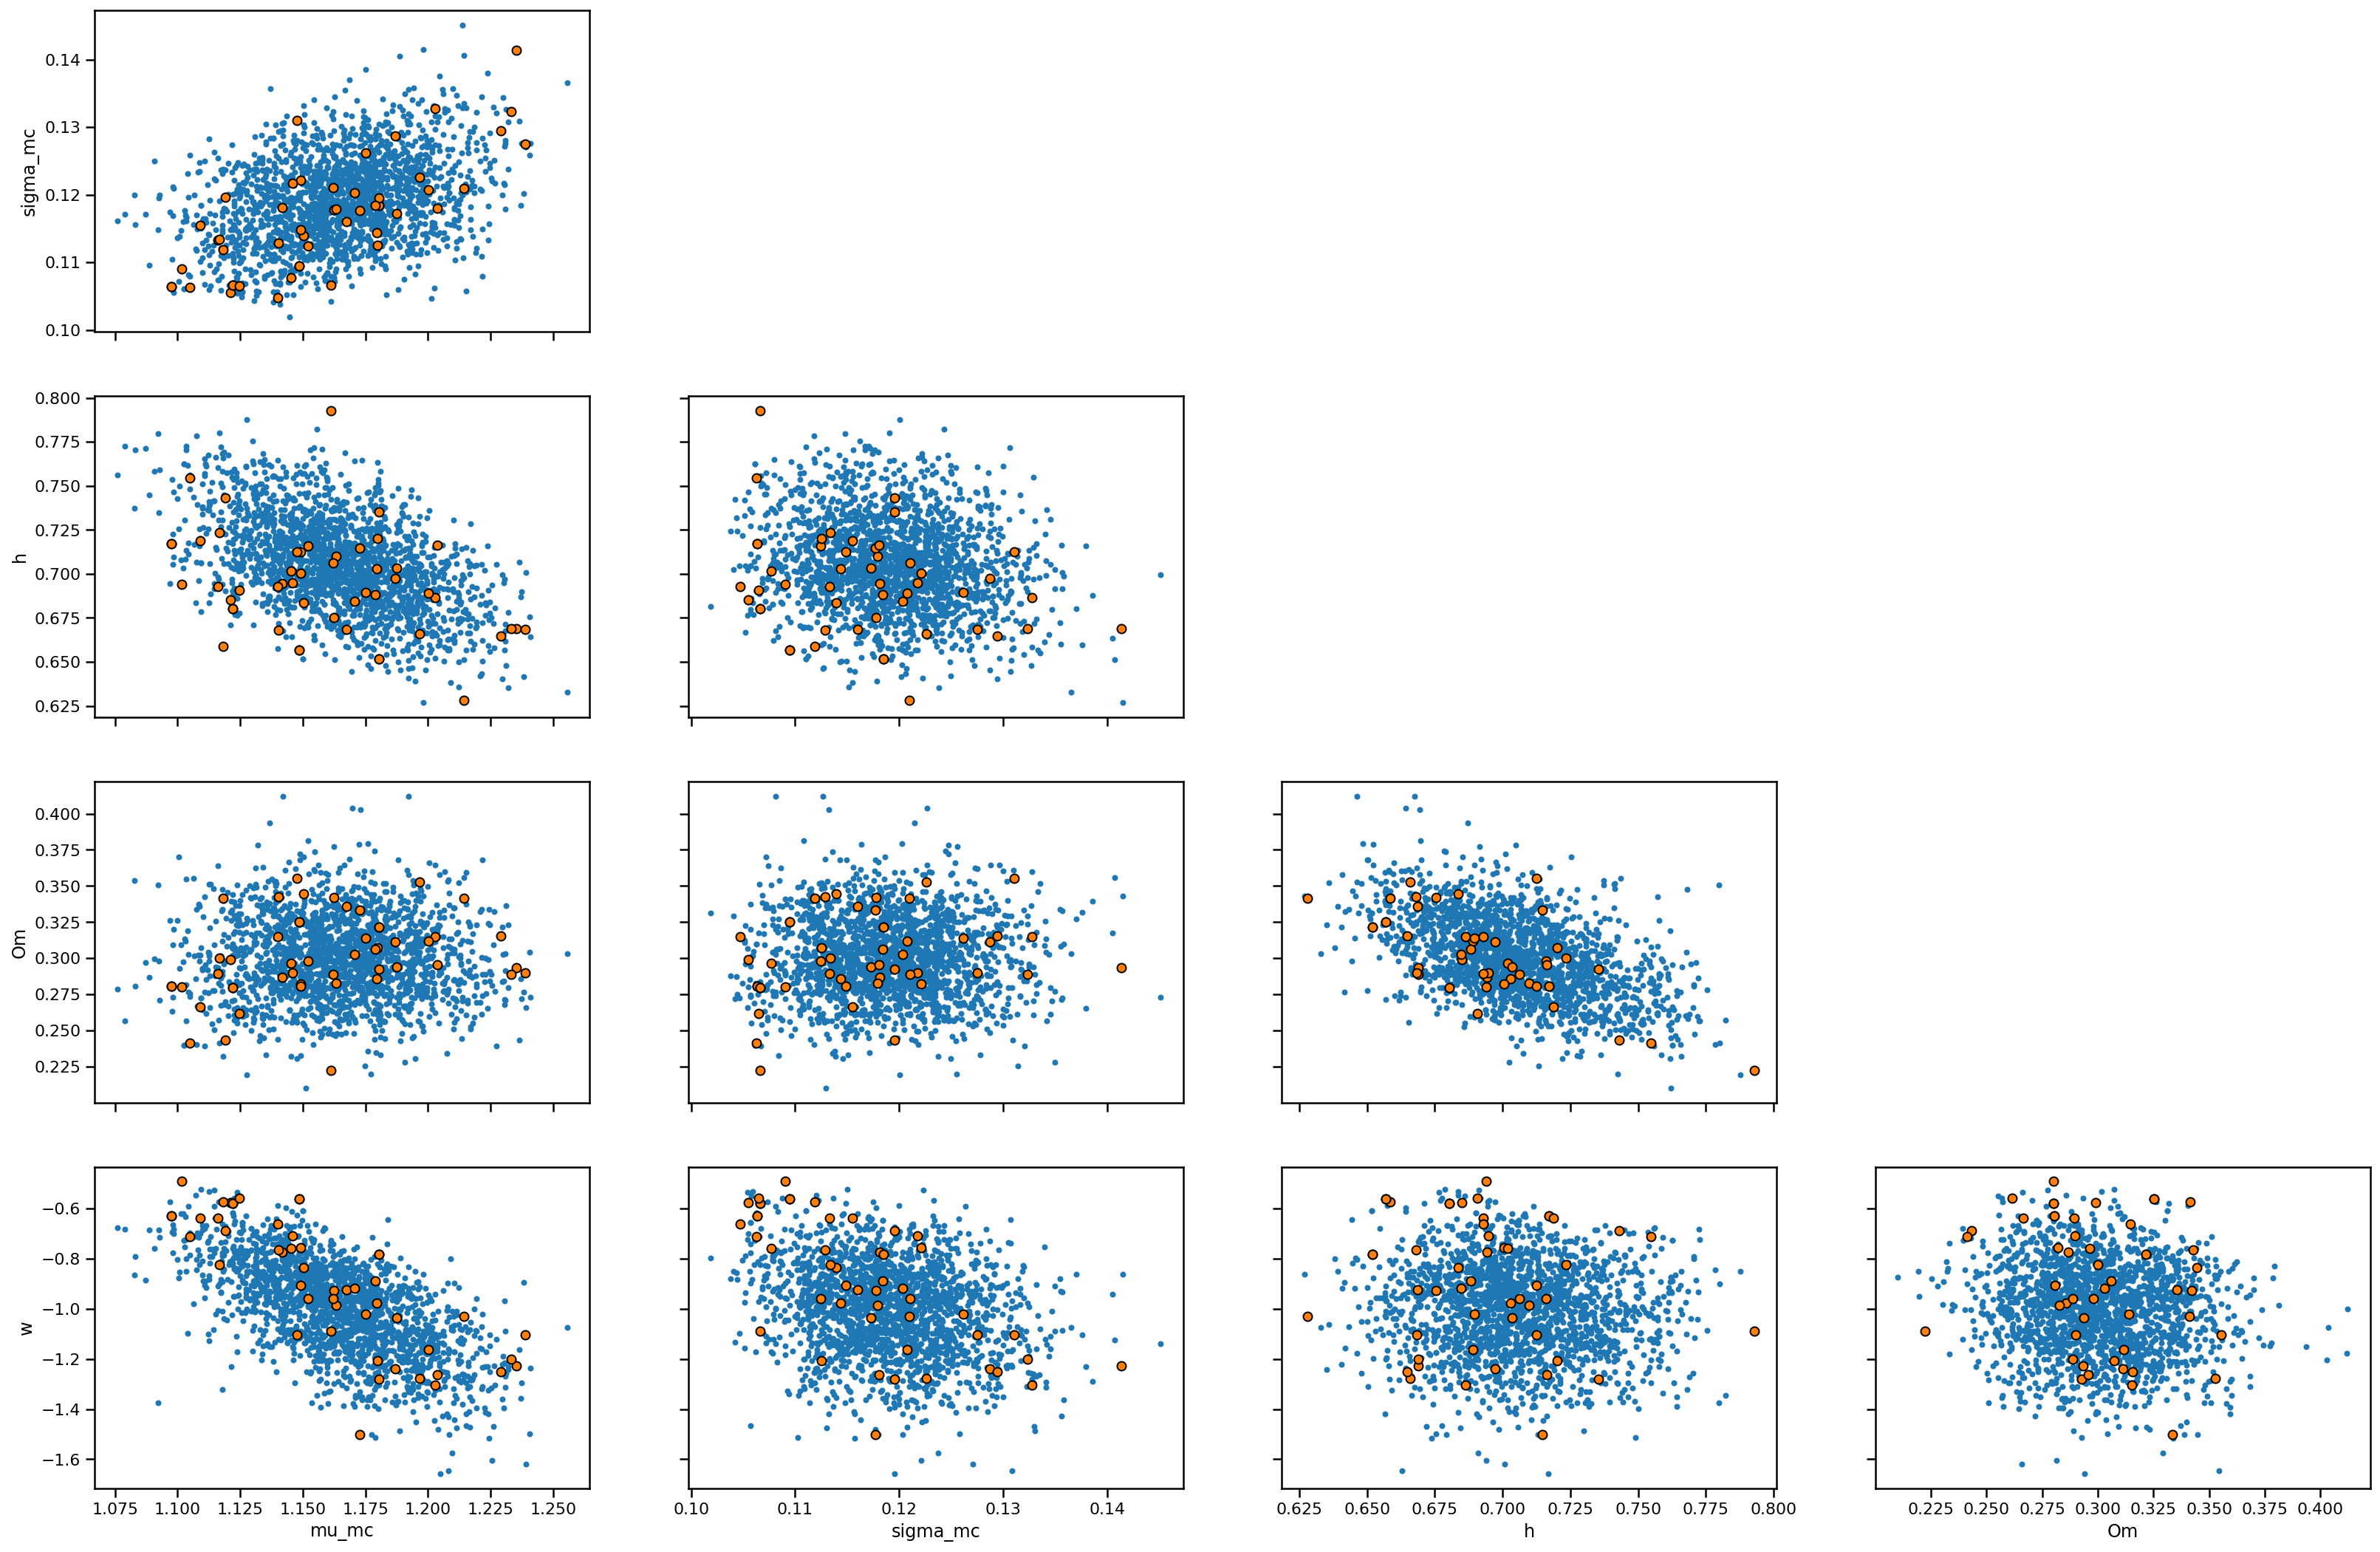

In [10]:
az.plot_pair(trace, var_names=['mu_mc', 'sigma_mc', 'h', 'Om', 'w'], divergences=True)